# Radiation Forces on Circumplanetary Dust

This example shows how to integrate circumplanetary dust particles under the action of radiation forces.  We use Saturn's Phoebe ring as an example, a distant ring of debris. 

We have to make sure we add all quantities in the same units.  Here we choose to use SI units.  We begin by adding the Sun and Saturn, and use Saturn's orbital plane as the reference plane:

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
sim.G = 6.674e-11 # SI units
sim.dt = 1.e4 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally
sim.add(m=1.99e30) # add Sun with mass in kg
sim.add(m=5.68e26, a=1.43e12, e=0.056, pomega = 0., f=0.) # Add Saturn at pericenter

Now let's set up `REBOUNDx` and add `radiation_forces`.  We have to pass which particle in the simulation corresponds to the radiation source, and the speed of light:

In [2]:
rebx = reboundx.Extras(sim)
rebx.add_radiation_forces(sim.particles[0], c=3.e8)

Here we show how to add two dust grains to the simulation in different ways.  Let's first initialize their orbits.  In both cases we use the orbital elements of Saturn's irregular satellite Phoebe, which the dust grains will inherit upon release (Tamayo et al. 2011).  Since the dust grains don't interact with one another, putting them on top of each other is OK.

In [3]:
a = 1.3e10 # in meters
e = 0.16
inc = 175*np.pi/180.
Omega = 0. # longitude of node
omega = 0. # argument of pericenter
f = 0. # true anomaly

Saturn = sim.particles[1]
# Add two dust grains with the same orbit
sim.add(primary=Saturn, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)
sim.add(primary=Saturn, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)

# Set up labels for convenience
p1 = sim.particles[2]
p2 = sim.particles[3]

Now we add the grains' physical properties.  **In order for particles to feel radiation forces, we have to set their `beta` parameter**.  $\beta$ is tha ratio of the radiation force to the gravitational force from the star (Burns et al. 1979).  One can either set it directly:

In [4]:
p1.beta = 0.01

or we can calculate it from more fundamental parameters.  REBOUNDx has a convenience function that takes the star's luminosity, and then grain's physical radius, bulk density, and radiation pressure coefficient Q_pr (Burns et al. 1979, equals 1 in the limit that the grain size is >> the radiation's wavelength).

In [5]:
grain_radius = 1.e-5 # grain radius in m
density = 1000. # kg/m^3 = 1g/cc
Q_pr = 1.
luminosity = 3.85e26 # Watts
p2.beta = rebx.rad_calc_beta(grain_radius, density, Q_pr, luminosity)

Now let's run for 100 years (about 3 Saturn orbits), and look at how the eccentricity varies over a Saturn year:

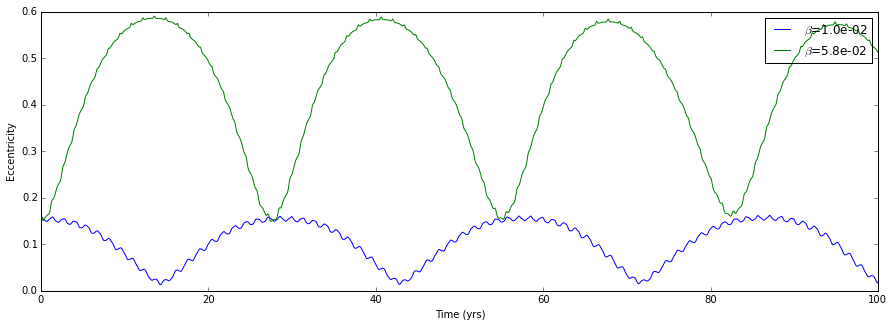

In [6]:
yr = 365*24*3600 # s
Noutput = 1000
times = np.linspace(0,100.*yr, Noutput)
e1, e2 = np.zeros(Noutput), np.zeros(Noutput)

sim.move_to_com() # move to center of mass frame first

for i, time in enumerate(times):
    sim.integrate(time)
    e1[i] = p1.calculate_orbit(primary=Saturn).e
    e2[i] = p2.calculate_orbit(primary=Saturn).e
   
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times/yr, e1, label=r"$\beta$={0:.1e}".format(p1.beta))
ax.plot(times/yr, e2, label=r"$\beta$={0:.1e}".format(p2.beta))
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Eccentricity')
plt.legend()